In [1]:
import os
import psycopg2
import pandas as pd
import re
import shutil
import time
from psycopg2.extras import DictCursor
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [2]:
 # https://www.psycopg.org/docs/extras.html?highlight=dictcursor#psycopg2.extras.DictCursor
 con = psycopg2.connect(database="swhgd-popular-4k", user="postgres", password="")
 print("connected with Database successfully")

connected with Database successfully


In [3]:
@contextmanager
def timed_cursor():
    start_time = time.time()
    yield con.cursor(cursor_factory=DictCursor)
    print("--- %s seconds ---" % (time.time() - start_time))

In [4]:
def get_cve(row):
    rv = list()
    for regex in regexes:
        rv.extend(list(set(regex.findall(row['msg']))))
    if not rv and regex_sql_inj.search(row['msg']):
        rv.append("sql_injection")
    return rv

In [5]:
def copy_cwe(row):
    if not isinstance(row['cve_data'], str):
        return row['cwe_group']
    if 'CWE' in row['cve_data']:
        return row['cve_data']
    return row['cwe_group']

In [6]:
def create_statistics(df, lang):
    cwe_counts = df['cwe_group'].value_counts()
    cwe_counts.to_csv(os.path.join(res_dir, f'count_cwe_groups_{lang}.csv'), header=False)

    severity_counts = df['severity'].value_counts()
    severity_counts.to_csv(os.path.join(res_dir, f'count_severity_{lang}.csv'), header=False)

    avg_impacts = df['impact_score'].describe()
    avg_impacts.to_csv(os.path.join(res_dir, f'stat_impact_score_{lang}.csv'), header=False)

    # Bug Fix -> "Array must be all same time zone"
    df['commit_date'] = pd.to_datetime(df['commit_date'], utc=True)

    stat_yearly = df[['commit_date']]
    stat_yearly = stat_yearly.groupby(stat_yearly.commit_date.dt.year).count()
    stat_yearly.to_csv(os.path.join(res_dir, f'fixes_per_year_{lang}.csv'), header=False)

    cwe_group_year = df[['commit_date', "cwe_group"]]
    cwe_group_year = cwe_group_year.groupby([cwe_group_year.commit_date.dt.year, 'cwe_group']).count()
    cwe_group_year.to_csv(os.path.join(res_dir, f'count_cwe_groups_by_year_{lang}.csv'), header=False)

In [7]:
def run_on(lang):
    df = None
    with timed_cursor() as cur:
        query = f"SELECT * FROM cve_revs_{lang}"
        df = pd.read_sql_query(query, con=con)
    if df is None:
        print("Query failed")
        return

    # Extract CVE number
    df['cve_data'] = df.apply(lambda row: get_cve(row), axis=1)

    # Explode revisions with multiple CVE
    df = df.explode("cve_data")

    # CVEs should be all uppered
    df['cve_data'] = df['cve_data'].str.upper()

    # Clean unnecessary fields
    del df['msg']
    # Bug Fix -> There is no column named cve
    # del df['cve']

    # Drop false rows
    df = df[df.cve_data.notnull()]

    # JOIN the cve_list to the data
    df = df.merge(cve_list, on="cve_data", how="left")
    # Bug Fix -> Add published_date,severity,impact_score
    df = pd.merge(df,cvss_list[['cve_data','published_date','severity','impact_score']],on='cve_data', how='left')
    # Copy CWE if CWE was used in commit message
    df['cwe_group'] = df.apply(lambda row: copy_cwe(row), axis=1)

    # Save csv
    df.to_csv(os.path.join(res_dir, rf'result_{lang}.csv'))

    create_statistics(df, lang)

In [8]:
def select_random_rows(table, limit):
    sql = f"select * from {table} order by random() limit {limit};"
    with timed_cursor() as cur:
        df = pd.read_sql_query(sql, con=con)
        with open(os.path.join(res_dir, f"sample_from_{table}.txt"), 'w') as f:
            for rec_index, rec in df.iterrows():
                f.write(f'------- commit message {rec_index} starts -------\n')
                f.write(rec['msg'])
                f.write('\n------- commit message ends -------\n')

In [9]:
res_dir = '../../data/results'

regex_cve = re.compile(r"(CVE-\d{4}-\d{4,})", re.IGNORECASE)
regex_cwe = re.compile(r"(CWE-[\d]{1,4})", re.IGNORECASE)
regex_nvd = re.compile(r"(NVD .+)", re.IGNORECASE)
regex_sql_inj = re.compile(r"sql ?injection", re.IGNORECASE)

regexes = [regex_cve, regex_cwe, regex_nvd]

cve_list = pd.read_csv(os.path.join("../../data/cve_parsed", "cve_related_problems.csv"), sep="\t")
# Bug Fix -> Rename CVE to cve_data
cve_list.rename(columns={"CVE": "cve_data", "Problem": "cwe_group"}, inplace=True)

# CVSS Scores
# Bug Fix -> Add published_date,severity,impact_score -> This Data wasn't available previously 
cvss_list = pd.read_csv(os.path.join("../../data/cve_parsed", "cve_cvss_scores.csv"), sep="\t")
# Bug Fix -> Rename Columns - CVE, "Published Date", "Impact Score"
cvss_list.rename(columns={"CVE": "cve_data", "Published Date": "published_date", "Impact Score": "impact_score"}, inplace=True)

if os.path.exists(res_dir):
    shutil.rmtree(res_dir)
os.makedirs(res_dir)
run_on("js")
run_on("py")

# select_random_rows("cve_revs_py", 348)
# select_random_rows("cve_revs_js", 352)

--- 0.002999544143676758 seconds ---
--- 0.0070002079010009766 seconds ---


## Statistics 1 

Count Delta(Time span between published_date of CWE & commit_date of CWE)

**RQ2** - Reaction Times to Security Issues:

Here we can observe that it takes average 89 days for python and 21 days for JavaScript comminities to fix a vulnerablity.



21.03925925925926

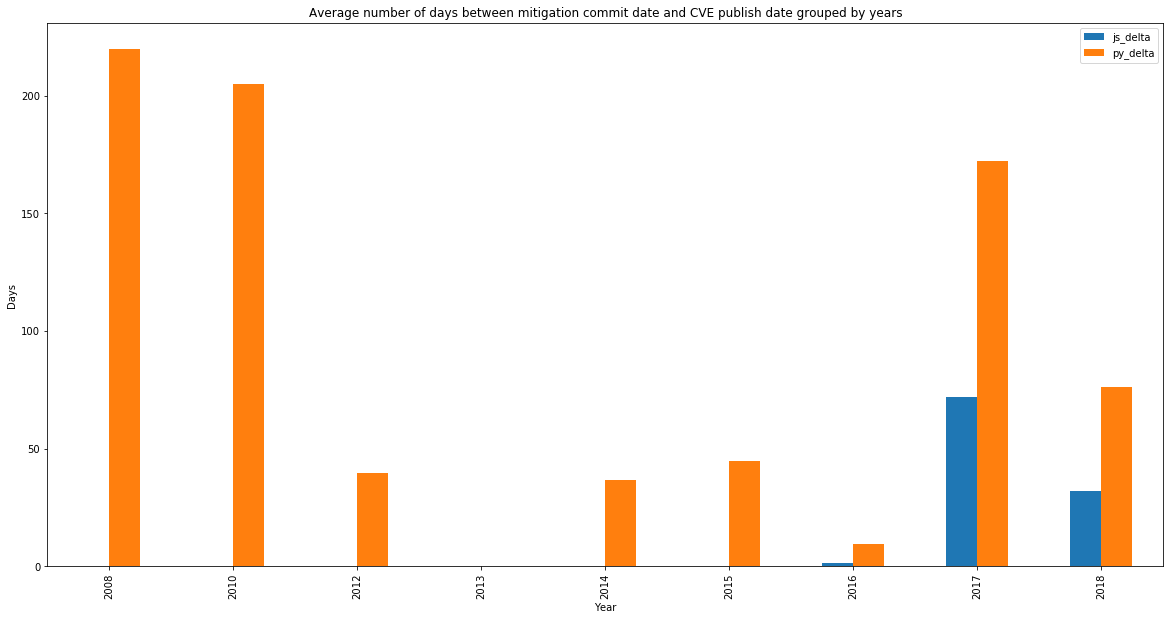

In [17]:
# stat1
js_result_csv = pd.read_csv( os.path.join("../../data/results", "result_js.csv"),index_col=0).dropna(subset=['published_date'])
py_result_csv = pd.read_csv( os.path.join("../../data/results", "result_py.csv"),index_col=0).dropna(subset=['published_date'])

js_result_csv[['published_date','commit_date']] = js_result_csv[['published_date','commit_date']].apply(pd.to_datetime,utc=True)
js_result_csv['js_delta'] = ((js_result_csv['commit_date'] - js_result_csv['published_date']).dt.days).apply(lambda val: val if val>0 else 0)
js_stat_1 = js_result_csv.query('js_delta >= 0').drop(columns=['impact_score']).groupby(js_result_csv['commit_date'].dt.year).agg('mean')

py_result_csv[['published_date','commit_date']] = py_result_csv[['published_date','commit_date']].apply(pd.to_datetime,utc=True)
py_result_csv['py_delta'] = ((py_result_csv['commit_date'] - py_result_csv['published_date']).dt.days).apply(lambda val: val if val>0 else 0)
py_stat_1 = py_result_csv.query('py_delta >= 0').drop(columns=['impact_score']).groupby(py_result_csv['commit_date'].dt.year).agg('mean')

stat_1 = pd.concat([js_stat_1, py_stat_1], axis=1).query('js_delta > 0 or py_delta > 0')
stat_1_ax = stat_1.plot(kind='bar', title='Average number of days between mitigation commit date and CVE publish date grouped by years', figsize=(20,10))
stat_1_ax.set(xlabel="Year", ylabel="Days")
stat_1['js_delta'].mean()

## Statistics 2
Count JS CWEs, Py CWEs & Common CWEs.

**RQ1** - Typical Security Issue Types:

The CWEs having at least 10 references in either of the analyzed languages are as follows:  
- 'CWE-119' 
- 'CWE-125'
- 'CWE-185'
- 'CWE-189' 
- 'CWE-20'
- 'CWE-200'
- 'CWE-310'
- 'CWE-399'
- 'CWE-601'
- 'CWE-787'
- 'CWE-79'

Interestingly, except for CWE-200 & CWE-185 that is the type of the vulnerabilities mitigated in nearly around 20 & 10 commits in both languages, each of the other six CWE groups can be attributed to either JavaScript or Python projects

Original Logic on stat2.py had one bug:
```
next(js_r)
next(py_r)
```
Above code will skip 1 line from csv files while reading, however there are no headers in `count_cwe_groups_js.csv` or `count_cwe_groups_py.csv` 

JavaScript CVEs: 25
Python CVEs: 30
Common CVEs: 41
The CWEs having at least 10 references in either of the analyzed languages are as follows
['CWE-119', 'CWE-125', 'CWE-185', 'CWE-189', 'CWE-20', 'CWE-200', 'CWE-310', 'CWE-399', 'CWE-601', 'CWE-787', 'CWE-79']


,js,py
CWE-119,3.0,17.0
CWE-125,13.0,1.0
CWE-185,9.0,12.0
CWE-189,NaN,18.0
CWE-20,6.0,69.0
CWE-200,20.0,18.0
CWE-310,NaN,14.0
CWE-399,1.0,31.0
CWE-601,20.0,35.0
CWE-787,13.0,NaN


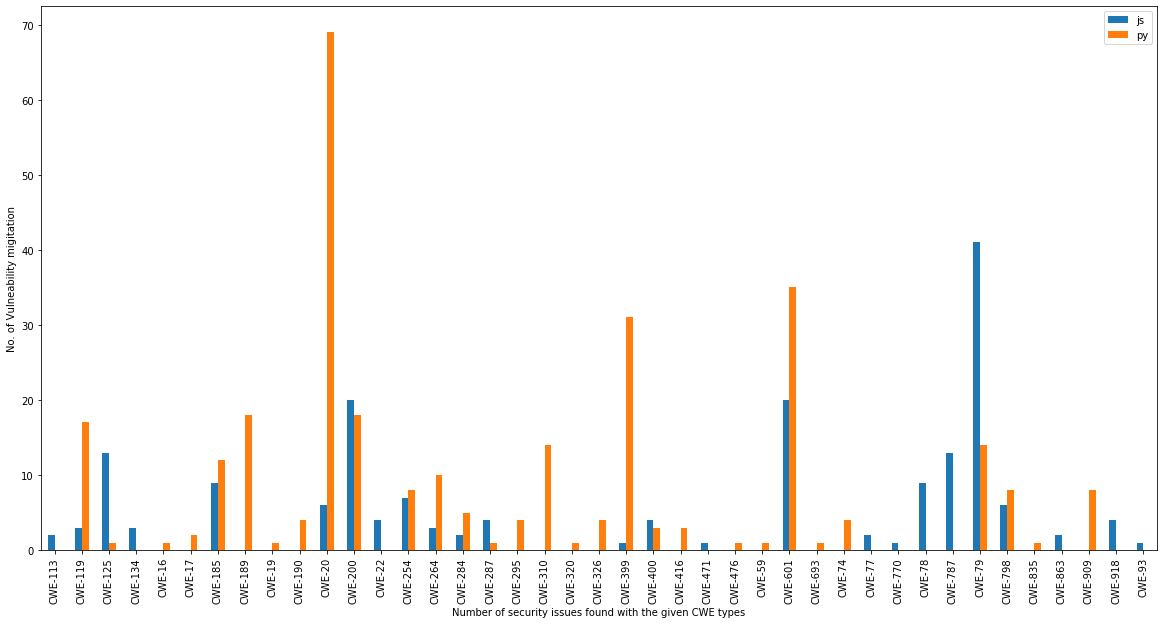

In [30]:
# Stat2
js_count_cwe_groups_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_js.csv"), header=None, names=['CWE','js'], index_col='CWE')
py_count_cwe_groups_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_py.csv"), header=None, names=['CWE','py'], index_col='CWE')

# Excluding Columns 'NVD-CWE-noinfo' & 'NVD-CWE-Other'
js_count_cwe_groups_csv = js_count_cwe_groups_csv.filter(regex=r'CWE-.[\d]+', axis=0)
py_count_cwe_groups_csv = py_count_cwe_groups_csv.filter(regex=r'CWE-.[\d]+', axis=0)

# ax = js_csv.plot(kind='bar',figsize=(20,10))
# py_csv.plot(ax=ax, kind='bar')

stat_2 = pd.concat([js_count_cwe_groups_csv, py_count_cwe_groups_csv], axis=1)
js_count = len(stat_2['js'].dropna())
py_count = len(stat_2['py'].dropna())
print("JavaScript CVEs: "+ str(js_count))
print("Python CVEs: "+ str(py_count))
print("Common CVEs: "+ str(len(stat_2)))
stat_2_ax = stat_2.plot(kind='bar', figsize=(20,10))
stat_2_ax.set(xlabel="Number of security issues found with the given CWE types", ylabel="No. of Vulneability migitation")
stat_2 = stat_2.query('js > 10 or py >10')
# stat_2.plot(kind='bar', figsize=(20,10))
print('The CWEs having at least 10 references in either of the analyzed languages are as follows')
print(stat_2.index.to_list())
stat_2
# plt.show()

## Statistics 3
Count CWEs (per year) which are present in list given below if delta is >0: 
 
"CWE-79", "CWE-399", "CWE-200", "CWE-20", "CWE-264", "CWE-400", "CWE-119", "CWE-22"

,js_delta,py_delta
CWE-119,232.333333,107.176471
CWE-20,0.000000,33.623188
CWE-200,0.000000,43.555556
CWE-22,0.000000,NaN
CWE-264,0.000000,1.800000
CWE-399,396.000000,0.129032
CWE-400,0.500000,1.000000
CWE-79,13.731707,0.285714


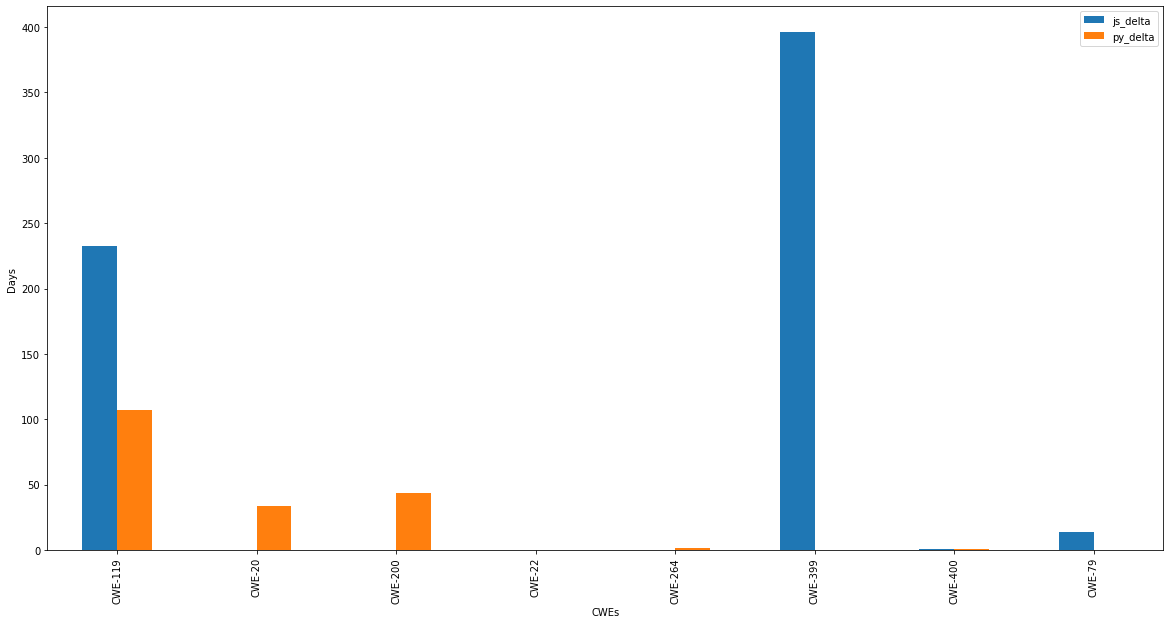

In [12]:
# stat3.py
CWE = [
        "CWE-79",
        "CWE-399",
        "CWE-200",
        "CWE-20",
        "CWE-264",
        "CWE-400",
        "CWE-119",
        "CWE-22"
      ]

js_stat_3 = js_result_csv.query('js_delta >= 0 and cwe_group in @CWE').drop(columns=['impact_score']).groupby(js_result_csv['cwe_group']).agg('mean')
py_stat_3 = py_result_csv.query('py_delta >= 0 and cwe_group in @CWE').drop(columns=['impact_score']).groupby(py_result_csv['cwe_group']).agg('mean')

stat_3 = pd.concat([js_stat_3, py_stat_3], axis=1)
stat_3_ax = stat_3.plot(kind='bar', figsize=(20,10))
stat_3_ax.set(xlabel="CWEs", ylabel="Days")
stat_3

## Statistics 4
Count CWEs (per year) which are present in list given below:  
"CWE-79",
"CWE-399",
"CWE-200",
"CWE-20",
"CWE-264",
"CWE-400",
"CWE-119",
"CWE-22"

Original Logic on stat4.py had one bug:
```
next(js_reader)
next(py_reader)
```
Above code will skip 1 line from csv files while reading, however there are no headers in `count_cwe_groups_by_year_js.csv` or `count_cwe_groups_by_year_py.csv` 

js_count  py_count
CWE     year                    
CWE-119 2008       NaN       2.0
        2010       NaN      10.0
        2015       NaN       3.0
        2017       3.0       2.0
CWE-20  2012       NaN      10.0
        2013       NaN      12.0
        2014       NaN       2.0
        2017       NaN      45.0
        2018       6.0       NaN
CWE-200 2015       2.0       2.0
        2016       2.0       8.0
        2017       NaN       1.0
        2018      16.0       7.0
CWE-22  2018       4.0       NaN
CWE-264 2011       NaN       1.0
        2013       NaN       4.0
        2014       NaN       1.0
        2016       3.0       4.0
CWE-399 2012       NaN      24.0
        2013       NaN       6.0
        2015       NaN       1.0
        2018       1.0       NaN
CWE-400 2017       NaN       3.0
        2018       4.0       NaN
CWE-79  2014      12.0       NaN
        2015       6.0       1.0
        2016       7.0      10.0
        2017       3.0       3.0
        2018      13.0       NaN

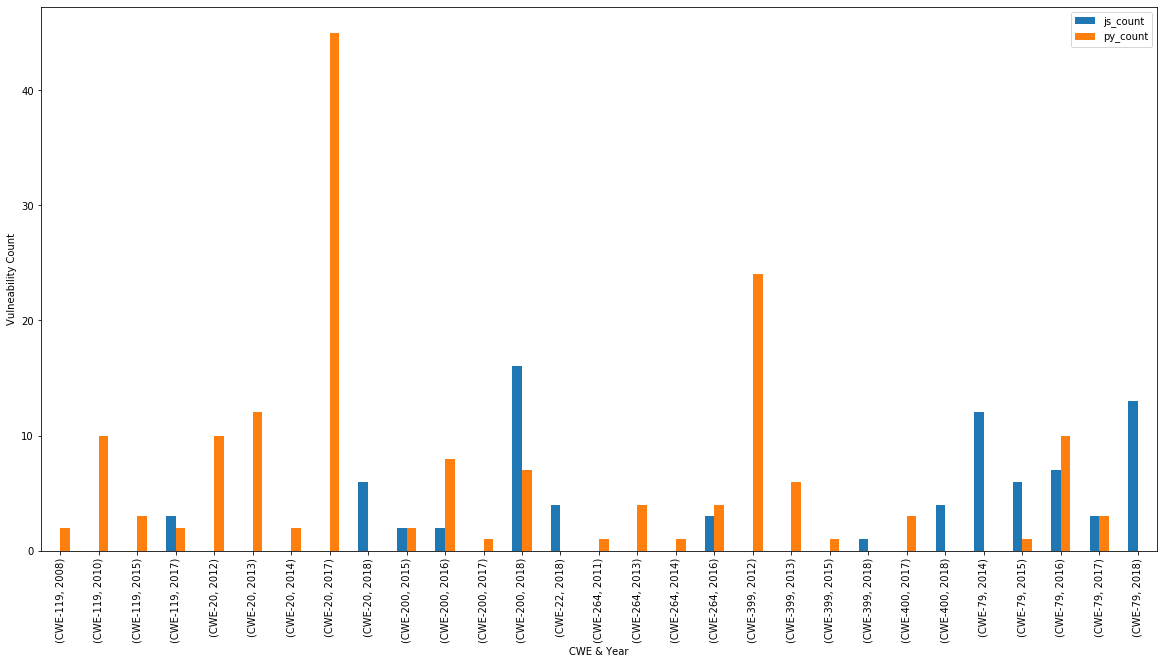

In [13]:
# stat4
CWE = [
        "CWE-79",
        "CWE-399",
        "CWE-200",
        "CWE-20",
        "CWE-264",
        "CWE-400",
        "CWE-119",
        "CWE-22"
      ]
js_cwe_groups_by_year_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_by_year_js.csv"), header=None, names=['year','CWE','js_count'], index_col='year')
py_cwe_groups_by_year_csv = pd.read_csv( os.path.join("../../data/results", "count_cwe_groups_by_year_py.csv"), header=None, names=['year','CWE','py_count'], index_col='year')

js_stat_4 = js_cwe_groups_by_year_csv.query('CWE in @CWE').groupby(['CWE','year']).sum()
py_stat_4 = py_cwe_groups_by_year_csv.query('CWE in @CWE').groupby(['CWE','year']).sum()

stat_4 = pd.concat([js_stat_4, py_stat_4], axis=1)
stat_4_ax = stat_4.plot(kind='bar', figsize=(20,10))
stat_4_ax.set(xlabel="CWE & Year", ylabel="Vulneability Count")
stat_4

## Statistics 5
Count CWE & Vulnerability per year for python and javascript Projects

Original Logic on stat5.py was buggy:

```
if year not in yearly:
    yearly[year] = count
yearly[year] += count
```
Above code will add count 2 times if year is not found

js_count  py_count
CWE     year                    
CWE-113 2018       2.0       NaN
CWE-119 2008       NaN       2.0
        2010       NaN      10.0
        2015       NaN       3.0
        2017       3.0       2.0
...                ...       ...
CWE-835 2017       NaN       1.0
CWE-863 2018       2.0       NaN
CWE-909 2018       NaN       8.0
CWE-918 2018       4.0       NaN
CWE-93  2017       1.0       NaN

[71 rows x 2 columns]

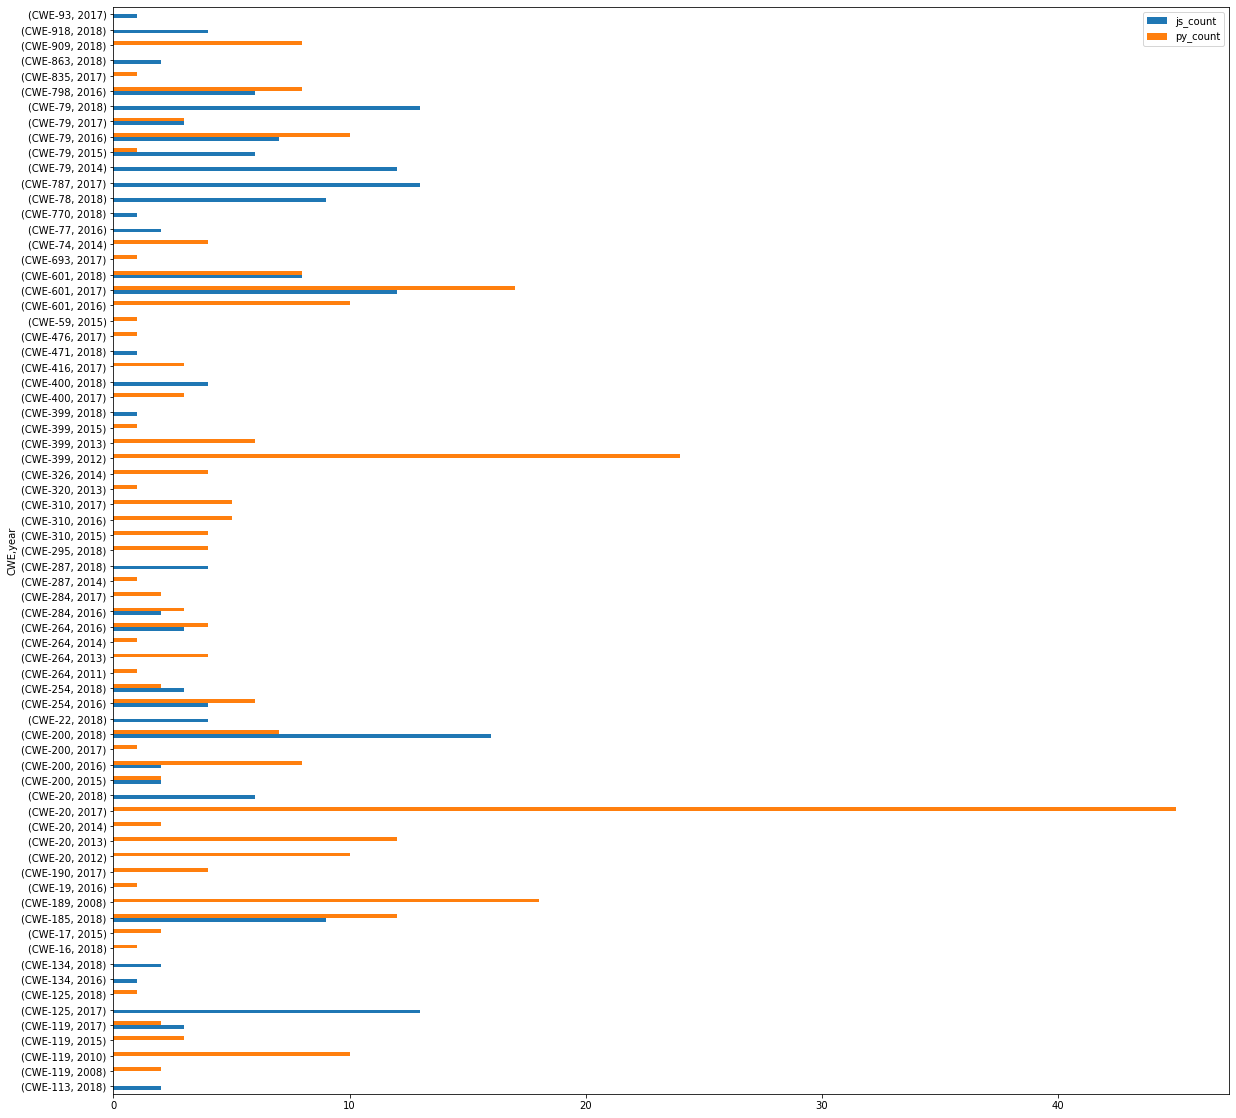

In [14]:
# Stat5
js_stat_5 = js_cwe_groups_by_year_csv.groupby(['CWE','year']).sum()
py_stat_5 = py_cwe_groups_by_year_csv.groupby(['CWE','year']).sum()

js_stat_5['js_count'].groupby('year').sum().to_csv(os.path.join("../../data/results", "yearly_commits_js.csv"))
py_stat_5['py_count'].groupby('year').sum().to_csv(os.path.join("../../data/results", "yearly_commits_py.csv"))

stat_5 = pd.concat([js_stat_5, py_stat_5], axis=1).filter(regex=r'CWE-.[\d]+', axis=0)
stat_5.plot(kind='barh', figsize=(20,20))
stat_5